In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping

In [6]:
def random_transform(image):
    choice = random.randint(0, 5)

    rows, cols, _ = image.shape

    if choice == 0: # Translation
        tx, ty = random.randint(-20, 20), random.randint(-20, 20)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 1: # Rotation
        angle = random.randint(-30, 30)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 2: # Scaling
        scale_factor = random.uniform(0.8, 1.2)
        return cv2.resize(image, None, fx=scale_factor, fy=scale_factor)

    elif choice == 3: # Skewing
        pts1 = np.float32([[5,5],[20,5],[5,20]])
        pt1 = 5+10*np.random.uniform()-10/2
        pt2 = 20+10*np.random.uniform()-10/2
        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
        M = cv2.getAffineTransform(pts1,pts2)
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 4: # Perspective distortion
        pts1 = np.float32([[5,5],[20,5],[5,20],[20,20]])
        pts2 = np.float32([[0,0],[20,5],[5,20],[20,20]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        return cv2.warpPerspective(image, M, (cols, rows))

    else: # Pincushion distortion
        distortion = np.float32([1, 1, 0, 0])
        camera_matrix = np.eye(3)
        return cv2.undistort(image, camera_matrix, distortion)


In [40]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [41]:
# Preprocess images
new_shape = (32, 32)
train_images = np.array([cv2.resize(img, new_shape) for img in train_images])
test_images = np.array([cv2.resize(img, new_shape) for img in test_images])

train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images[..., tf.newaxis].astype("float32")
test_images = test_images[..., tf.newaxis].astype("float32")

In [42]:
# creating validation images val_images
val_size = int(len(train_labels)*0.25)

train_images , val_images= train_images[val_size:], train_images[:val_size]
print("train_images size: ", train_images.shape, " and val_images size: ", val_images.shape)

train_labels , val_labels= train_labels[val_size:], train_labels[:val_size]
print("train_labels size: ", train_labels.shape, " and val_labels size: ", val_labels.shape)

train_images size:  (45000, 32, 32, 1)  and val_images size:  (15000, 32, 32, 1)
train_labels size:  (45000,)  and val_labels size:  (15000,)


In [43]:
# Build the ViT model
input_shape = (*new_shape, 1)
patch_size = 4
num_heads = 2
num_patches = (new_shape[0] // patch_size) * (new_shape[1] // patch_size)
projection_dim = 32
num_transformer_layers = 2
mlp_head_units = [64, 32]

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(3, (3, 3), padding="same")(inputs)  # Convert to 3 channels
x = tf.keras.layers.Rescaling(1.0 / 255)(x)  # Rescale
x = tf.keras.layers.Conv2D(32, (patch_size, patch_size), strides=patch_size)(x)
x = tf.keras.layers.Reshape((num_patches, 32))(x)

for _ in range(num_transformer_layers):
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    x2 = tf.keras.layers.Add()([attention_output, x])
    x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = tf.keras.layers.Conv1D(64, 2, padding="same", activation="relu")(x3)
    x3 = tf.keras.layers.Dropout(0.1)(x3)
    x3 = tf.keras.layers.Conv1D(32, 2, padding="same")(x3)
    x = tf.keras.layers.Add()([x3, x2])

x = tf.keras.layers.GlobalAveragePooling1D()(x)
for dim in mlp_head_units:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [45]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model with early stopping
# history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 200 ,batch_size = 20, callbacks=[early_stopping])
history = model.fit(train_images, train_labels, validation_data = (val_images, val_labels), verbose = 1, epochs=2, batch_size=32, callbacks=[early_stopping])

Epoch 1/2
1407/1407 [==============================] - 148s 96ms/step - loss: 2.3044 - accuracy: 0.1088 - val_loss: 2.3011 - val_accuracy: 0.1127
Epoch 2/2
1407/1407 [==============================] - 140s 100ms/step - loss: 2.3017 - accuracy: 0.1119 - val_loss: 2.3009 - val_accuracy: 0.1127


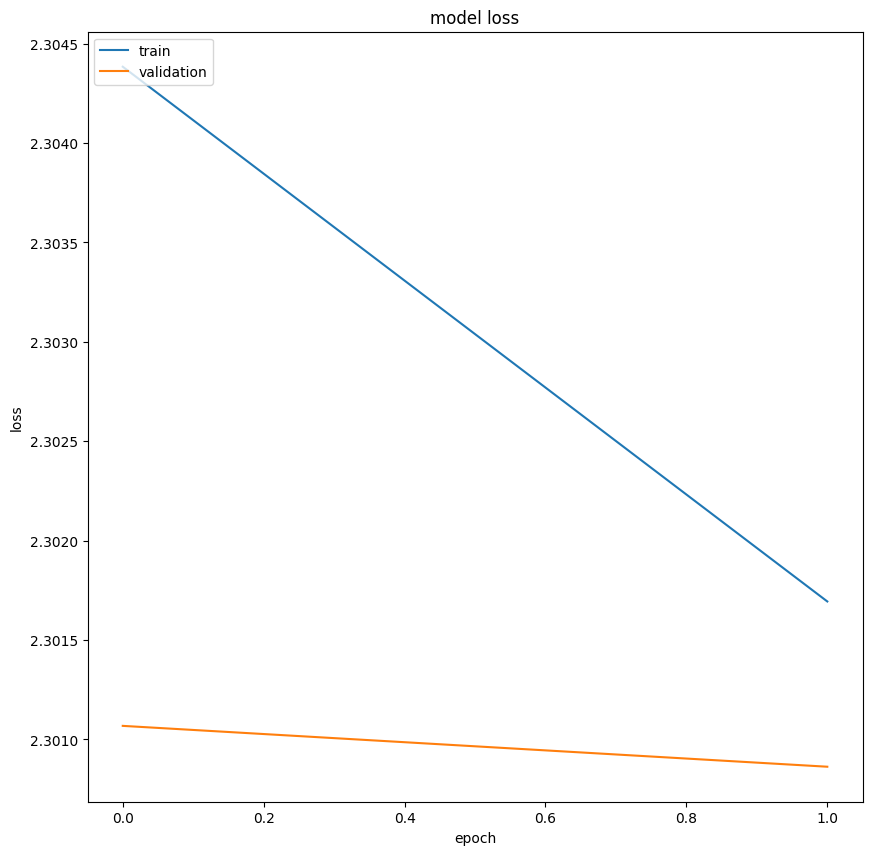

In [49]:
#checking the performance on taining_data
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [50]:
# Evaluate and report as before...

# Applying transformations to test images
# Applying transformations to test images
# Applying transformations to test images
# Applying transformations to test images
transformed_test_images = []
for img in test_images:
    transformed_img = random_transform(img)
    transformed_test_images.append(transformed_img)
# resizing transformed_test_images into (32, 32)
new_shape = (32, 32)
transformed_test_images = np.array([cv2.resize(img, new_shape) for img in transformed_test_images])

# Checking for shape consistency
first_shape = transformed_test_images[0].shape
for i, img in enumerate(transformed_test_images):
    if img.shape != first_shape:
        print(f"Inconsistent shape at index {i}: expected {first_shape}, but got {img.shape}")

# Add more diagnostic code if needed



In [22]:
# Evaluating the model
test_loss, test_acc = model.evaluate(transformed_test_images, test_labels)

# Getting Precision, Recall, and F1 Score
y_pred = model.predict(transformed_test_images)
y_pred_labels = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, y_pred_labels, average='macro')

print(f"Test Accuracy: {test_acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


313/313 [==============================] - 10s 28ms/step
Test Accuracy: 0.11349999904632568
Precision: 0.01135
Recall: 0.1
F1 Score: 0.0203861697350696


c:\Users\salah\.conda\envs\vision-transformer\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# Evaluating the model
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Getting Precision, Recall, and F1 Score
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, y_pred_labels, average='macro')

print(f"Test Accuracy: {test_acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

313/313 [==============================] - 12s 35ms/step
Test Accuracy: 0.11349999904632568
Precision: 0.01135
Recall: 0.1
F1 Score: 0.0203861697350696


c:\Users\salah\.conda\envs\vision-transformer\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
